## Описание проекта "Определение стоимости автомобилей"

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

Нашей задачей будет разработка модели машинного обучения для предсказания примерной рыночной стоимости автомобиля на основе исторических данных. Пользователь должен будет указать характеристики своего автомобиля и получить его примерную стоимость. 

На основе поставленной задачи подготовим план действий:

- изучим данные, проверим пропуски, дубликаты, распределения значений признаков;
- сделаем предобработку признаков разных типов данных;
- подготовим данные к обучению с учитом особенностей моделей разных модулей;
- после обучения моделей выведем показания метрик в итоговую таблицу для анализа и оценки качества этих моделей, дадим иттговое заключение.

##  1. Подготовка данных

### 1.1 Изучение данных

импорты

In [1]:
import time
import warnings

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import (
    train_test_split,
    KFold,
    RandomizedSearchCV
)
from sklearn.preprocessing import (
    StandardScaler,
    OneHotEncoder,
    OrdinalEncoder
)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

warnings.filterwarnings('ignore')
pd.set_option("display.float_format", lambda x: "%.2f" % x)

RS = 17

изучим данные, проверим на дубликаты, пропуски

In [ ]:
try:
    df = pd.read_csv('/datasets/autos.csv')
except:
     df = pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv')

NameError: name 'pd' is not defined

In [3]:
display(df.head(1))
df_copy = df.copy()
print(df.info())
print()
print('-'*50)
print(f'Количество пропусков = {df.isna().sum().sum()}')
print(f'Количество дубликатов = {df.duplicated().sum().sum()}')
print('-'*50)
print(f'Процент потери данных при удалении пропусков = \
    {(1-df_copy.dropna().shape[0]/df.shape[0])*100:.2f} %')

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

### 1.2 Предобработка численных признаков

Удаление пропусков приведет к большой потере данных, поэтому будем снижать их процент путем заполнения/частичного удаления. Сначала удалим неинформативные признаки, т.к. они не вляиют на поведение цены авто. Также стоит удалить месяц регистрации, т.к. одним из ключевых признаков является именно год регистрации.

In [4]:
df = df.drop(
    ['DateCrawled','DateCreated','NumberOfPictures','LastSeen','RegistrationMonth','PostalCode'],
    axis=1)

df.head(1)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN


Теперь датасет содержит только актуальную информацию. Проверим датасет на пропуски

In [5]:
df.isna().sum()

Price                   0
VehicleType         37490
RegistrationYear        0
Gearbox             19833
Power                   0
Model               19705
Kilometer               0
FuelType            32895
Brand                   0
Repaired            71154
dtype: int64

Из таблицы видно, что пропуски содержатся только в категориальных признаках, один из которых бинарый. Далее следует в числовых признаках удалить аномалии/выбросы, в категориальных - устранить пропуски.

Числовые признаки: **'Price','RegistrationYear','Power'**. Объявим функцию, которая на вход принимает название признака, на выходе боксплот, для каждого признака масштаб по оси абсцисс вводится вручную для поиска границ лимитирования.

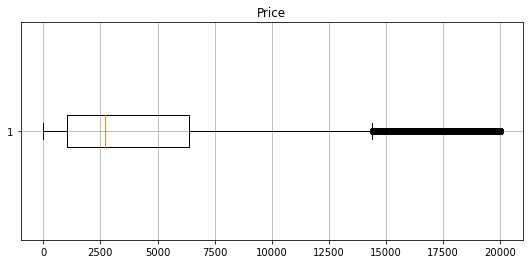

In [6]:
def boxplot_info(title):
    
    plt.figure(figsize=(9,4))
    plt.boxplot(df[title], vert=False)
    plt.grid(True)
    plt.title(title);
    
boxplot_info('Price')

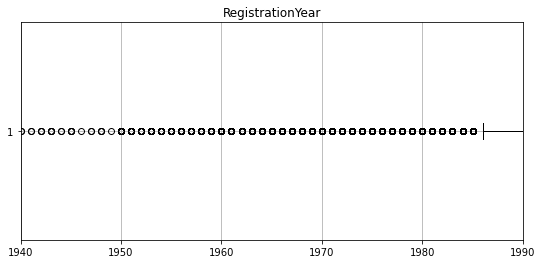

In [7]:
boxplot_info('RegistrationYear')
plt.xlim(1940,1990);

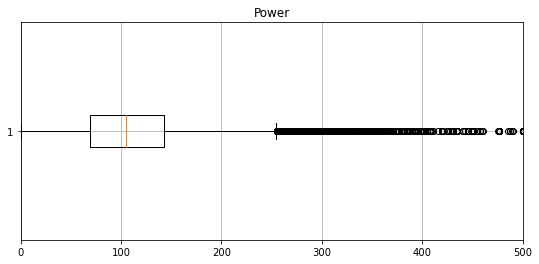

In [8]:
boxplot_info('Power')
plt.xlim(0,500);

**Вывод по графикам:**

- в признаке Price возьмем нижнюю границу за 5% квантиль, т.к. совсем низкие цены выглядят нелогично;
- в признаке RegistrationYear зададим диапазон 1980-2016, дата последней выгрузки данных 2016 год;
- в признаке Power зададим интервал от 5% квантиля до 460 л.с., т.к. меньше нижней границы машины с такой мощностью двигателя не актуальны, а свыше - дорогой лошадинный налог, авто невозможно будет перерегистрировать после покупки в связи с изменением заводской конструкции.

In [9]:
df = df[(df['Price'] > df['Price'].quantile(.05)) &
        (df['RegistrationYear'] >= 1980) &
        (df['RegistrationYear'] <= 2016) &
        (df['Power'] > df['Power'].quantile(.05)) &
        (df['Power'] <=460)]

### 1.3 Предобработка категориальных признаков

Категориальные признаки: **'VehicleType','Gearbox','Model','FuelType','Brand','Repaired','Kilometer'**

Проверив график для признака Kilometer видно, что он принимает строгие значения с равными периодами, значит его можно отнести к категоримальным, преобразуем его тип.

Создадим бинарную маску для признака Repaired. Для признаков Gearbox и Repaired можно заполнить значениями manual и 1 соответственно, т.к. АКПП используется не так давно и реже относительно МКПП, а если пользователь не указал наличие в прошлом ремонта, то по умолчанию будем считать это фактом, т.к. порядочный пользователь укажет факт отсутствия ремонта для удержания высокой цены авто

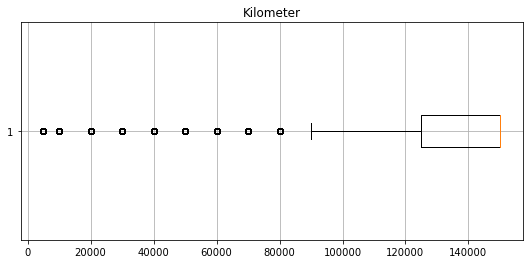

In [10]:
boxplot_info('Kilometer')

In [11]:
df.Kilometer = df.Kilometer.astype('object')
df.Repaired = df.Repaired.map({'yes':1,'no':0}).fillna(1).astype('int')
df.Gearbox = df.Gearbox.fillna('manual')

Объявим функцию для заполнения пропусков в оставшихся признаках, которая будет принимать на вход 2 признака для агрегации данных, по которым на выходе для 3его признака будет заполнять пропуск модой по группировке данных согласно методу transform.

In [12]:
def fillna_mode(col1, col2, col3):
    
    df[col3] = df.groupby([col1,col2])[col3].transform(
        lambda x: x.fillna(x.mode()[0] if not x.mode().empty else 'unknown')
    )
    
fillna_mode('RegistrationYear','Brand','Model')
fillna_mode('Brand','Model','VehicleType')
fillna_mode('Brand','Model','FuelType')

# проверка
display(df.isna().sum())
print('-'*50)
print(f'Количество пропусков в итоговом датасете  = {df.isna().sum().sum()}')
print(f'Количество дубликатов в итоговом датасете = {df.duplicated().sum()}')
print('-'*50)

Price               0
VehicleType         0
RegistrationYear    0
Gearbox             0
Power               0
Model               0
Kilometer           0
FuelType            0
Brand               0
Repaired            0
dtype: int64

--------------------------------------------------
Количество пропусков в итоговом датасете  = 0
Количество дубликатов в итоговом датасете = 43064
--------------------------------------------------


### 1.4 Результаты предобработи

Осталось удалить  дубликаты, проверить размер итогового датасета и провести корреляцию признаков

--------------------------------------------------
Количество дубликатов = 0
--------------------------------------------------
Размер итогового датасета (245981, 10)
--------------------------------------------------

                *************** КОРРЕЛЯЦИИ ПРИЗНАКОВ ***************


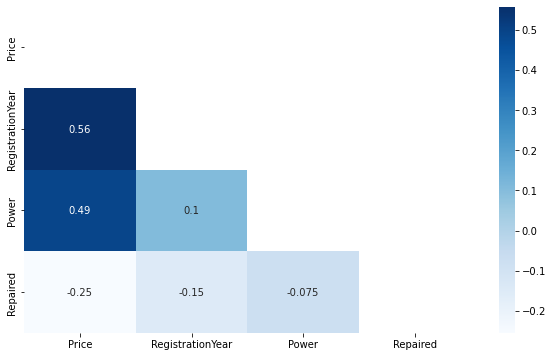

In [13]:
df = df.drop_duplicates().reset_index(drop=True)
df_copy = df.copy()
print('-'*50)
print(f'Количество дубликатов = {df.duplicated().sum().sum()}')
print('-'*50)
print(f'Размер итогового датасета {df.shape}')
print('-'*50)
print()
plt.figure(figsize=(10,6))
print(' '*15,'*'*15, 'КОРРЕЛЯЦИИ ПРИЗНАКОВ','*'*15)
sns.heatmap(df.corr(), annot=True, cmap = 'Blues', mask=np.triu(np.ones_like(df.corr())));

### 1.5 Вывод

**Вывод по предобработке:**

- удалены неинформативные признаки;
- удалены выбросы/аномалии в числовых признаках;
- заполнены пропуски в категориальных признаках;
- удалены дубликаты, датасет приведен к дальнейшей работе.

Была составлена таблица корреляций, обнаружена средняя корреляция между 2мя признаками и таргетом, которые улучшат качество предсказания модели. 

## 2. Обучение моделей

### 2.1 Подготовка данных к обучению

Для дальнейшей работы с моделями бустинга преобразуем категориальные признаки в тип category, подготовим выборки и таргет

In [14]:
for i in df.columns:
    if df[i].dtype == 'object':
        df[i] = df[i].astype('category')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 245981 entries, 0 to 245980
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   Price             245981 non-null  int64   
 1   VehicleType       245981 non-null  category
 2   RegistrationYear  245981 non-null  int64   
 3   Gearbox           245981 non-null  category
 4   Power             245981 non-null  int64   
 5   Model             245981 non-null  category
 6   Kilometer         245981 non-null  category
 7   FuelType          245981 non-null  category
 8   Brand             245981 non-null  category
 9   Repaired          245981 non-null  int32   
dtypes: category(6), int32(1), int64(3)
memory usage: 8.2 MB


In [15]:
X, X_test, y, y_test = train_test_split(
    df.drop('Price', axis=1),
    df['Price'],
    test_size=.25,
    random_state=RS)

print(f'Размер трейна {X.shape, y.shape}')
print(f'Размер теста  {X_test.shape, y_test.shape}')

Размер трейна ((184485, 9), (184485,))
Размер теста  ((61496, 9), (61496,))


### 2.2 Кодирование признаков

Разделим признаки на числовые и категориальные, для каждого проведем обработку, подготовим признаки для разных моделей модуля sklearn: OneHot для линеных моделей, Ordinal для деревьев.

In [17]:
cat = ['VehicleType','Gearbox','Model','FuelType','Brand','Kilometer']
num = ['RegistrationYear','Power']


col_trans_lin = ColumnTransformer(
                 [('ohe', OneHotEncoder(handle_unknown='ignore', drop='first', sparse=False), cat),
                  ('scaler', StandardScaler(), num)],
                    remainder='passthrough'
)

col_trans_trees = ColumnTransformer(
                 [('oe', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), cat),
                  ('scaler', StandardScaler(), num)],
                    remainder='passthrough'
)

### 2.3 Обучение

Далее наша задача обучить разные модели на трейне, проверить итоговые замеры метрики и времени исполнения и на основе результатов выбрать одну модель для проверки на тесте. Сначала проверим 3  модели модуля skalearn: дерево, лес и регрессию, далее 3 модели бустинга: LightGBM, CatBoost, XGBoost. Для каждой модели будет проводить cv отдельно, т.к. согласно тз нужно замерить не только значение метрики, но и время обучения и предсказания модели. 

Объявим функцию, которая на вход принимает модель, ее параметры, набор признаков для трейна и теста, на выходе - значение метрики на cv, время обучения и предсказания, а также значение метрики на тесте, которые мы выведем только для модели с лучшим показателем метрики rmse на валиде. Метрика на тесте была включена в функцию сразу для упрощения расчетов и вывода в следующем пункте.

In [18]:
def model_metrics(model, params):
    
    regressor = RandomizedSearchCV(
         model, 
         params, 
         cv = KFold(5, shuffle=True, random_state=RS),
         scoring='neg_root_mean_squared_error',
         n_jobs=-1,
         verbose=10
    )
    regressor.fit(X, y)
    
    rmse_cv = -regressor.best_score_.round(4) 
    best_params = regressor.best_params_
    time_fit = regressor.cv_results_['mean_fit_time'][regressor.best_index_].round(4)
    time_predict = regressor.cv_results_['mean_score_time'][regressor.best_index_].round(4)
    best_model = regressor.best_estimator_
    
    return rmse_cv, time_fit, time_predict, best_params, best_model

Каждую модель с ее парметрами заложим в функцию и получим метрики, выводить их будем в датафрейме в пункте "Анализ моделей" для презентабельного отображения результатов.

### 2.4 Sklearn

**DecisionTree**

In [19]:
%%time
pipe_dt = Pipeline([
    ('tree_transform', col_trans_trees),
    ('dt', DecisionTreeRegressor(random_state=RS))
])
params_dt = {
    'dt__max_depth':[15]
}
dt_rmse_cv, dt_time_fit, dt_time_predict, dt_best_params, dt_best_model = model_metrics(
    pipe_dt, 
    params_dt
)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
--------------------------------
Simulated successfully, next up
--------------------------------
CPU times: total: 2.27 s
Wall time: 43 s


**RandomForest**

In [42]:
%%time
pipe_rf = Pipeline([
    ('tree_transform', col_trans_trees),
    ('rf', RandomForestRegressor(random_state=RS))
])
params_rf = {
    'rf__max_depth':[25],
    'rf__n_estimators':[300]
}
rf_rmse_cv, rf_time_fit, rf_time_predict, rf_best_params, rf_best_model = model_metrics(
    pipe_rf, 
    params_rf
)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
--------------------------------
Simulated successfully, next up
--------------------------------
CPU times: total: 4min 13s
Wall time: 10min 27s


1682.98

**LinearRegresion**

In [21]:
%%time
pipe_rf = Pipeline([
    ('lin_transform', col_trans_lin),
    ('lr', LinearRegression())
])
lr_rmse_cv, lr_time_fit, lr_time_predict, lr_best_params, lr_best_model = model_metrics(
    pipe_rf, 
    {}
)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
--------------------------------
Simulated successfully, next up
--------------------------------
CPU times: total: 13.6 s
Wall time: 22.7 s


### 2.5 Boosting

**LightGBM**

In [22]:
%%time
pipe_lgbm = Pipeline([
    ('lgbm', LGBMRegressor(random_state=RS))
])
params_lgbm = {
    'lgbm__n_estimators':[500],
    'lgbm__learning_rate':[0.1]
    'lgbm__max_depth':[25]
}
lgbm_rmse_cv, lgbm_time_fit, lgbm_time_predict, lgbm_best_params, lgbm_best_model = model_metrics(
    pipe_lgbm, 
    params_lgbm
)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
--------------------------------
Simulated successfully, next up
--------------------------------
CPU times: total: 17.6 s
Wall time: 18.8 s


**XGBoost**

In [27]:
%%time
pipe_xgb = Pipeline([
    ('tree_transform', col_trans_trees),
    ('xgb', XGBRegressor(random_state=RS))
])
params_xgb = {
    'xgb__n_estimators':[100],
    'xgb__max_depth':[10],
    'xgb__learning_rate':[0.1]
}
xgb_rmse_cv, xgb_time_fit, xgb_time_predict, xgb_best_params, xgb_best_model = model_metrics(
    pipe_xgb, 
    params_xgb
)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
--------------------------------
Simulated successfully, next up
--------------------------------
CPU times: total: 1min 13s
Wall time: 1min 19s


{'xgb__n_estimators': 100, 'xgb__max_depth': 10, 'xgb__learning_rate': 0.1}

**CatBoost**

In [39]:
%%time
pipe_cat = Pipeline([
    ('cat', CatBoostRegressor(cat_features=cat, verbose=False, random_state=RS))
])
params_cat = {
    'cat__iterations':[500],
    'cat__learning_rate':[0.5]
}
cat_rmse_cv, cat_time_fit, cat_time_predict, cat_best_params, cat_best_model = model_metrics(
    pipe_cat, 
    params_cat,
)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
--------------------------------
Simulated successfully, next up
--------------------------------
CPU times: total: 7min 52s
Wall time: 5min 36s


### 2.6 Вывод

**Вывод по итогам обучения моделей:**

- данные были поготовлены для обучения моделей;
- было проведено обучение моделей с минимальным набором значений параметров для минимизации времени обучения;
- для каждой модели по итогу обучения заложены и расчитаны значения метрик на трейне и тесте, время обучения и предскзания.

## 3. Анализ моделей

### 3.1 Результаты работы моделей

выведем результаты работы моделей в таблицу

In [43]:
pd.DataFrame(
    {'rmse cv':[dt_rmse_cv, 
                rf_rmse_cv, 
                lr_rmse_cv, 
                lgbm_rmse_cv, 
                xgb_rmse_cv,
                cat_rmse_cv],
     
     'time fit':[dt_time_fit,
                 rf_time_fit,
                 lr_time_fit,
                 lgbm_time_fit,
                 xgb_time_fit,
                 cat_time_fit],
     
     'time predict':[dt_time_predict,
                     rf_time_predict,
                     lr_time_predict,
                     lgbm_time_predict,
                     xgb_time_predict,
                     cat_time_predict]
    },
    index=['Decision Tree',
           'Random Forest',
           'Linear Regression',
           'LightGBM',
           'XGBoost',
           'CatBoost']     
)

,rmse cv,time fit,time predict
Decision Tree,1945.91,2.80,0.20
Random Forest,1682.98,303.19,61.75
Linear Regression,2474.88,14.96,0.70
LightGBM,1585.73,8.79,2.60
XGBoost,1596.40,45.23,0.58
CatBoost,1613.23,251.47,0.37


по результатам моделью с лучшим балансом значений метрики и времени обучения/предсказания является LightGBM. далее проверим ее качество на тестовой выборке

### 3.2 Тестирование

In [41]:
lgbm_rmse_test =  mean_squared_error(
    y_test, lgbm_best_model.predict(X_test), squared=False)

display(pd.DataFrame({
     'LightGBM Regressor':[lgbm_rmse_cv,
                          lgbm_rmse_test,
                          lgbm_time_fit,
                          lgbm_time_predict]
     },
     index=['rmse valid',
            'rmse test',
            'time_fit',
            'time_predict']
        )
)

,LightGBM Regressor
rmse valid,1585.73
rmse test,1581.19
time_fit,8.79
time_predict,2.60


## 4. Вывод по итогам проекта

   Нашей задачей является выбор модели согласно требованиям заказчика: качество предсказания, время обучения и время предсказания. Последний критерий можно не учитывать при выборе модели, т.к. время предсказания всех моделей быстрое, не более 2 сек. Выбор модели определяется балансом между показателем метрики и временем обучения, при этом важно учесть одну особенность исследования: выбор делается в пользу модели, которая показала лучший баланс НА ТЕСТИРУЕМОЙ ПЛАТФОРМЕ, т.к. разные платформы имеют разные ресурсы для проведения исследования. Для оптимизации выбора по итогам исследования представлена таблица с результатами, для каждой модели рассчитаны параметры реализации и метрики на трейне и тесте. В любой момент времени можно вывести метрики выбранной модели для дальнешей работы и оптимизации.

   Согласно результатам таблицы исследования данных и работы моделей на представленной платформе (ЯндексПрактикум) оптимальный баланс значение метрики / время обучения показала модель градинентного бустинга CatBoost. Для простоты вывода метрик модели объявим функцию, которая на вход принимает переменную, в которой храянтся все метрики модели, собранные воедино, на выходе получим таблицу с метриками. Для дальнейшей работы с данной моделью следует реализовать ее отдельно и подобрать точные параметры на основе апрксимальных.